# Curso BancoEstado-CMM: Aprendizaje de Máquinas Avanzado 
**Autores:** Taco de Wolff, Nicolas Caro y Felipe Tobar  

**Fecha:** 27 deciembre, 2019

# Módulo 9 - Redes Bayesianes
Instalar con `conda install pomegranate`.

In [33]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import time
import seaborn; seaborn.set_style('whitegrid')
import numpy as np
import networkx
import pandas as pd 

from pomegranate import *

## Introducción

El eje central de este modulo se desarrolla en torno a los modelos gráficos
probabilísticos (PGM). En términos generales, este tipo de modelo busca una
representación compacta para distribuciones de probabilidad conjunta de la
forma $p(\mathbf{x} | \mathbf{\theta})$, valiéndose de los fundamentos matemáticos
proporcionados por la teoría de grafos y de probabilidad.

Los PGM son ampliamente utilizados en tareas de razonamiento bajo incertidumbre,
tales como predicción, monitorio y diagnósticos médicos, además de tareas de
estimación de riesgos y toma de decisiones.


### Modelos gráficos dirigidos

Toda distribución de probabilidad conjunta $p(\mathbf{x} ) = p(x_1, x_2, \ldots x_v)$  se puede
representar de la forma:
\begin{equation}
	\label{eq:regla_cadena}
	p(\mathbf{x} ) = p(x_1)p(x_2 | x_1 )p(x_3 |  x_1, x_2) \ldots p(x_v |  x_1, x_2, \ldots , x_{v-1})
\end{equation}

El problema con esta expresión es la dificultad computacional subyacente al cálculo de
distribuciones condicionales de la forma $p(x_{t} |  x_1,\ldots, x_{t-1} )$
cuando el número de variables incidentes $t$ aumenta.

En efecto, si se asume $x_{t+1} \perp  x_{1}, \ldots, x_{t-1} | x_t$. Es decir,
las observaciones futuras $x_{t+1}$ son independientes del pasado $ x_{1}, \ldots,
x_{t-1}$, dado el estado presente $x_{t}$. La probabilidad conjunta se reduce entonces a:

\begin{equation}
\label{eq:markov_prop}
p(\mathbf{x} ) = p(x_1) \prod_{t = 2}^{v} p(x_t  |  x_1,\ldots , x_{t-1}) = p(x_1) \prod_{t = 2}^{v} p(x_t  | x_{t-1})
\end{equation}

De lo cual se obtiene una expresión más simple.

Modelar la independencia condicional entre las variables permite entonces reducir la
complejidad de representación para la distribución conjunta. En particular, la elección anterior se conoce como **propiedad de
Markov**.

En un contexto general, las relaciones de independencia condicional entre variables aleatorias
de dimensión arbitraria, se modelan utilizando **diagramas de independencia** o **modelos gráficos**. Estos se valen de un conjunto
consistente de $\mathcal{V} = \lbrace{1 \ldots , V} \rbrace$ vértices (o nodos) y $\mathcal{E} =\lbrace {(s,t): s,t \in \mathcal{V}} \rbrace$ aristas  para formar una estructura matemática conocida como **Grafo** $G=(\mathcal{V}, \mathcal{E})$.

Los grafos permiten representar mediante nodos $v = 1, \ldots, \mathcal{V}$ las variables aleatorias del modelo,
mientras que la presencia o ausencia de aristas entre estos nodos, permite teorizar sobre las relaciones de dependencia condicional entre variabes de un modelo.

Una **red bayesiana** es un modelo gráfico probabilístico, cuyo grafo subyacente es un **grafo dirigido acíclico** (DAG). Todo DAG posee un **ordenamiento topológico**, es decir, los nodos de cualquier DAG pueden ser numerados de manera tal, que todo nodo padre posea una numeración inferior a sus nodos hijos. Esta característica permite enriquecer la formulación de la propiedad de Markov, usando la estructura gráfica como componente adicional, de
esta forma, se puede reformular a una **propiedad ordenada de Markov** en modelos gráficos dirigidos:

\begin{equation}
	\label{eq:Markov_ordenado}
	x_s \perp  x_{pred(s) \setminus pa(s)} ~ | ~  x_{pa(s)}
\end{equation}

Es decir, un nodo $x_s$ es independiente de aquellos predecesores, menores en orden topológico,
a sus padres $ x_{pred(s) \setminus pa(s)}$, dados sus nodos padres $x_{pa(s)}$. De
manera equivalente, un nodo $x_s$ solo depende de sus padres inmediatos $x_{pa(s)}$ y no de
todos sus predecesores.

De esta forma, la probabilidad conjunta de un modelo gráfico dirigido, que cumple la **propiedad
ordenada de Markov**, se puede descomponer de la forma:
\begin{equation}
\label{eq:markov_prop_ord}
p(\mathbf{x} ) = \prod_{t = 1}^{V} p(x_t  | x_{pa(t)})
\end{equation}

Con el fin de explorar las posibilidades de este tipo de modelos e introducir conceptos
referentes a la notación de estos, se pasan a estudiar los siguientes ejemplos:


## Monty Hall

Monty Hall fue un show de juegos en estados unidos, en el que se daba al concursante a elegir entre tres puertas, una de ellas permitía ganar auto como premio, las otras dos conducían a una cabra. Después elegir una puerta, el anfitrión abre una de las otras dos puertas en las que hay cabra, luego ofrece la oportunidad al concursante de cambiar su puerta previamente seleccionada. El problema consiste en encontrar una estrategia que maximice la probabilidad de ganar el auto.¿Conviene más cambiar de elección, mantener la elección o realmente no se ve afectada la probabilidad de ganar al cambiar de elección?

Es intuitivo creer que al cambiar de puerta no se afecta la probabilidad de ganar, pero en realidad la estrategia ganadora corresponde a **siempre cambiar de puerta**. Con redes bayesianas es posible explorar este problema.

El problema explicado en Wikipedia: https://en.wikipedia.org/wiki/Monty_Hall_problem

### Interpretación probabilistica

Supongamos que se tienen tres variables aleatorias: Concursante $ C \in \{1, 2, 3\} $, Anfitrión $ H \in \{1, 2, 3\} $ y el premio $ P \in \{1, 2, 3 \} $. La probabilidad de que el premio esté detrás de una puerta aleatoria viene dada por $ P(P=1) = P(P=2) = P(P=3) = \frac{1}{3} $. Además, el concursante seleccionará una puerta aleatoriamente, luego $ P(C=1) = P(C=2) = P(C=3) = \frac{1}{3} $. Construimos una red Bayesiana así:

In [ ]:
from IPython.display import Image
Image('monty.png')

In [ ]:
# Los concursantes eligen la puerta inicialmente aleatoriamente
guest = DiscreteDistribution({'A': 1./3, 'B': 1./3, 'C': 1./3})

# La puerta con el premio es aleatorio
prize = DiscreteDistribution({'A': 1./3, 'B': 1./3, 'C': 1./3})

# El anfitrión depende del concursante y el premio 
'''
La tabla de probabilidad condicional se construye con la siguiente 
estructura:

E1 : primera elección
P  : Posción del premio 
Eh : elección del host
Pr : Probabilidad de elegir Eh dado E1 y P

[E1, Prize, Eh, Pr]

Donde Pr es la probabilidad de elegir Eh dadas las elecciones E1 y P.

'''

host = ConditionalProbabilityTable(
        [[ 'A', 'A', 'A', 0.0 ],
         [ 'A', 'A', 'B', 0.5 ],
         [ 'A', 'A', 'C', 0.5 ],
         [ 'A', 'B', 'A', 0.0 ],
         [ 'A', 'B', 'B', 0.0 ],
         [ 'A', 'B', 'C', 1.0 ],
         [ 'A', 'C', 'A', 0.0 ],
         [ 'A', 'C', 'B', 1.0 ],
         [ 'A', 'C', 'C', 0.0 ],
         [ 'B', 'A', 'A', 0.0 ],
         [ 'B', 'A', 'B', 0.0 ],
         [ 'B', 'A', 'C', 1.0 ],
         [ 'B', 'B', 'A', 0.5 ],
         [ 'B', 'B', 'B', 0.0 ],
         [ 'B', 'B', 'C', 0.5 ],
         [ 'B', 'C', 'A', 1.0 ],
         [ 'B', 'C', 'B', 0.0 ],
         [ 'B', 'C', 'C', 0.0 ],
         [ 'C', 'A', 'A', 0.0 ],
         [ 'C', 'A', 'B', 1.0 ],
         [ 'C', 'A', 'C', 0.0 ],
         [ 'C', 'B', 'A', 1.0 ],
         [ 'C', 'B', 'B', 0.0 ],
         [ 'C', 'B', 'C', 0.0 ],
         [ 'C', 'C', 'A', 0.5 ],
         [ 'C', 'C', 'B', 0.5 ],
         [ 'C', 'C', 'C', 0.0 ]], [guest, prize])

# Los estados contienen la distribution y un nombre
s1 = State(guest, name="guest")
s2 = State(prize, name="prize")
s3 = State(host, name="host")

In [ ]:
# Creamos la red Bayesiana
model = BayesianNetwork("Monty Hall Problem")

# Agregamos los estados (nodos de grafo) 
model.add_states(s1, s2, s3)

# Agregamos las aristas entre los nodos. El segundo nodo depende del primero nodo.
# El anfitrión depende del concursante y el premio
model.add_edge(s1, s3)
model.add_edge(s2, s3)

# Construir el modelo
model.bake()

### Calcular probabilidades
Supongamos que el concursante elige puerta A, y el anfitrión muestra puerta C. ¿Qué es la probabilidad que el premio is detrás puerta A o B, y nos conviene cambiar a puerta B?

Sí, la probabilidad que el auto es detrás puerta B es $\frac{2}{3}$ mientras la probabilidad que el auto es detrás A queda con $\frac{1}{3}$.

In [ ]:
model.predict_proba({'guest': 'A', 'host': 'C'})

¿Qué pasa si solo el anfitrión muestra puerta A aunque el concursante no elegió nada? Hay igual probabilidad que el auto es detrás B o C.

In [ ]:
model.predict_proba({'host': 'A'})

### Naive Bayes

Dado un problema de clasificación de vectores $\mathbf{x} = (x_1, \ldots , x_V)$ en $C$ clases. Es
posible modelar las variables de decisión $x_t$ como condicionalmente independientes dada la
categoría de clasificación:

\begin{equation}
	\label{eq:cond_nb}
	x_i \perp x_j ~| y =  c, ~~ i \neq j
\end{equation}

Si se usa este enfoque, se obtiene que la densidad condicional de clases toma la forma:

\begin{equation}
	\label{eq:naive_bayes}
	p(\mathbf{x} ~ | y = c) = \prod_{t=1}^{V}p(x_t ~ | y = c)
\end{equation}

Al parametrizar las distribuciones de densidad condicional, es posible obtener un modelo de
clasificación conocido como **clasificador Naive Bayes**, por medio de este, es posible clasificar mediante:

\begin{equation}
	p(y = c | \mathbf{x} = (x_1,\ldots,x_V)) =\frac{p(c)}{p(\mathbf{x})}\cdot\prod_{t=1}^{V}p(x_t ~ | y = c)
\end{equation}

La estructura de las relaciones de independencia inducidas por tal método. se pueden expresar según el siguiente grafo.

In [ ]:
from IPython.display import Image
Image('naive_bayes.png')

¿Como se relaciona con el ejemplo de Monty Hall?

A continuación se entrena un clasificador Naive Bayes. En este caso se tiene la altura, el peso, y el tamaño de los pies para clasificar si cierta persona es hombre o mujer.

In [ ]:
male = NormalDistribution.from_samples([1.75, 1.72, 1.67, 1.81, 1.76, 1.71])
female = NormalDistribution.from_samples([1.62, 1.59, 1.54, 1.68, 1.60, 1.61])

In [ ]:
male.plot(n=100000, edgecolor='c', color='c', bins=50, label='Hombre')
female.plot(n=100000, edgecolor='g', color='g', bins=50, label='Mujer')
plt.legend(fontsize=14)
plt.ylabel('n')
plt.xlabel('Altura (m)')
plt.show()

print("Hombre: distribución tiene mu = %4.2f m y sigma = %5.3f m" % (male.parameters[0], male.parameters[1]))
print("Mujer: distribución tiene mu = %4.2f m y sigma = %5.3f m" % (female.parameters[0], female.parameters[1]))

`X` contiene la altura, el peso, y el tamaño de los pies para 12 personas. `y` dice `0` para un hombre y `1` para una mujer. Entrenamos nuestro modelo de Bayes ingenuo y distribuciones Gaussianes.

In [ ]:
X = [
    [1.75, 70, 11],
    [1.72, 82, 12],
    [1.67, 95, 12],
    [1.81, 105, 13],
    [1.76, 85, 10],
    [1.71, 72, 11],
    [1.62, 55, 9],
    [1.59, 64, 6],
    [1.54, 59, 8],
    [1.68, 68, 7],
    [1.60, 75, 9],
    [1.61, 62, 8],
]
y = [0,0,0,0,0,0,1,1,1,1,1,1]

clf = NaiveBayes.from_samples(NormalDistribution, X, y)

In [ ]:
data = np.array([[1.85, 80, 12], [1.70, 105, 11], [1.675, 69, 10], [1.65, 70, 7], [1.60, 65, 8]])

for sample, probability in zip(data, clf.predict_proba(data)):
    print("[%5.3f m, %3.0f kg, %2.0f in]: %9.5f%% de probabilidad Hombre y %9.5f%% de probabilidad Mujer" % (sample[0], sample[1], sample[2], 100*probability[0], 100*probability[1]))

In [ ]:
for sample, result in zip(data, clf.predict(data)):
    print("Persona con [%5.3f m, %3.0f kg, %2.0f in] es %s." % (sample[0], sample[1], sample[2], "Mujer" if result else "Hombre"))

## Estructura de Redes Bayesianas

La estructura de una red bayesiana contiene las relaciones de independencia condicional relativos a una probabilidad condicional. De esta forma, si $X,Y,Z$ son variables aleatorias es posbile poseer relaciones de dependecia de la forma:

* Nodo Y secuencial :  $X \rightarrow Y \rightarrow Z$
* Nodo Y divergente :  $X \leftarrow Y \rightarrow Z$
* Nodo Y convergente: $X \rightarrow  Y \leftarrow Z$

En los primeros 2 casos, $X$ y $Z$ son condicionalmente independientes dada $Y$. Sin embargo, en el tercer caso, se tiene el fenomeno conocido como *explaining away* el cual corresponde a tener 2 *causas* asociadas a una misma *consecuencia*, por lo tanto, al conocer el efecto de una de las causas y la consecuencia, se pasa a conocer el valor de la última causa. Los fenomenos de dependencia anteriores se pueden extender a conjuntos de vértices en un grafo: es posible saber si el conjunto de variables $A$ es condicionalmente independiente de conjunto de variables $B$ dado el conjunto $C$ en función de la estructura de las aristas que los unen. Esto se estudia mediante el concepto de **D-separación** esto se reduce a buscar a utilizar el algoritmo **Bayes Ball**, este consiste en buscar caminos de la forma $X$-$Y$-$Z$ (nodo $Y$ entre $Z$ y $X$), si se conocen los valores de $Y$ este pasa a estar **sombreado** (en caso contrario no se altera su estado). El algoritmo consiste en *lanzar una bola* desde $X$ a $Z$, si la bola *llega* a $Z$ entonces $X$ y $Z$ *No* son independientes dado $Y$, para ello se siguen las reglas:

1. Si $Y$ es secuencial o divergente y no esta sombreado, la bola pasa a $Z$.
2. Si $Y$ es secuencial o divergente e $Y$ esta sombreado, la bola no llega a $Z$.
3. Si $Y$ es convergente y no esta sombreado, la bola no llega a $Z$.
3. Si $Y$ es convergente y esta sombreado, la bola pasa a $Z$.

Para especificar una red bayesiana, es necesario definir sus **parámetros**, estos corresponden a las probabilidades condicionales para cada nodo dada la estructura del grafo: 

* Los nodos raiz son probabilidades marginales.
* Los demas nodos representan probabilidades condicionales de una variable dada la información de sus nodos padres.

Es de bastente utilidad modelar redes considerando **valores discretos**, esto pues, aunque existen redes basadas en distribuciones continuas, estas se restringen a distribuciones bastante particulares (ej: variables gaussianas) y relaciones lineales entre ellas. Por lo anterior, es ventajoso utilizar **métodos de discretización** a la hora de trabajar con este tipo redes.

Finalmente, la especificación de parámetros - obtención de tablas de probabilidad condicional, se vuelve problematica cuando hay demasiados nodos padres y estados asociados a cada variable. 

# Red Bayesiana más compleja: ASIA
ASIA es un grafo de probabilidades involucrando cáncer de pulmon, bronquitis, tuberculosis y disnea.

Es una red simplificada y usada para diagnosticar pacientes en clínicas. Cada nodo representa un estado del paciente, por ejemplo "Visit To Asia" significa que el paciente fue recientemente a Asia. Las aristas representan las probabilidades entre nodos. Fumar aumenta la probabilidad de obtener cáncer de pulmones y bronquitis. Ambos aumentan la probabilidad de obtener disnea. Cáncer y tuberculosis salen en un rayos de X (pero bronquitis no).

La dirección de las aristas / flechas representa la causalidad. Los nodos padre influen en los nodos hijo.

In [ ]:
from IPython.display import Image
Image('Asia.jpg')

In [ ]:
asia = DiscreteDistribution( { 'True' : 0.5, 'False' : 0.5 } )

tuberculosis = ConditionalProbabilityTable(
    [[ 'True', 'True', 0.2 ],
     [ 'True', 'False', 0.8 ],
     [ 'False', 'True', 0.01 ],
     [ 'False', 'False', 0.99 ]], [asia])

In [ ]:
smoking = DiscreteDistribution( { 'True' : 0.5, 'False' : 0.5 } )

lung = ConditionalProbabilityTable(
    [[ 'True', 'True', 0.75 ],
     [ 'True', 'False', 0.25 ],
     [ 'False', 'True', 0.02 ],
     [ 'False', 'False', 0.98 ]], [smoking] )

bronchitis = ConditionalProbabilityTable(
    [[ 'True', 'True', 0.92 ],
     [ 'True', 'False', 0.08 ],
     [ 'False', 'True', 0.03 ],
     [ 'False', 'False', 0.97 ]], [smoking] )

tuberculosis_or_cancer = ConditionalProbabilityTable(
    [[ 'True', 'True', 'True', 1.0 ],
     [ 'True', 'True', 'False', 0.0 ],
     [ 'True', 'False', 'True', 1.0 ],
     [ 'True', 'False', 'False', 0.0 ],
     [ 'False', 'True', 'True', 1.0 ],
     [ 'False', 'True', 'False', 0.0 ],
     [ 'False', 'False', 'True', 0.0 ],
     [ 'False', 'False', 'False', 1.0 ]], [tuberculosis, lung] )

In [ ]:
xray = ConditionalProbabilityTable(
    [[ 'True', 'True', 0.885 ],
     [ 'True', 'False', 0.115 ],
     [ 'False', 'True', 0.04 ],
     [ 'False', 'False', 0.96 ]], [tuberculosis_or_cancer] )

In [ ]:
dyspnea = ConditionalProbabilityTable(
    [[ 'True', 'True', 'True', 0.96 ],
     [ 'True', 'True', 'False', 0.04 ],
     [ 'True', 'False', 'True', 0.89 ],
     [ 'True', 'False', 'False', 0.11 ],
     [ 'False', 'True', 'True', 0.96 ],
     [ 'False', 'True', 'False', 0.04 ],
     [ 'False', 'False', 'True', 0.89 ],
     [ 'False', 'False', 'False', 0.11 ]],
    [tuberculosis_or_cancer, bronchitis])

In [ ]:
s0 = State( asia, name="asia" )
s1 = State( tuberculosis, name="tuberculosis" )
s2 = State( smoking, name="smoker" )
s3 = State( lung, name="cancer" )
s4 = State( bronchitis, name="bronchitis" )
s5 = State( tuberculosis_or_cancer, name="T or C" )
s6 = State( xray, name="xray" )
s7 = State( dyspnea, name='dyspnea' )

In [ ]:
network = BayesianNetwork("asia")
network.add_nodes(s0, s1, s2, s3, s4, s5, s6, s7)

network.add_edge( s0, s1 )
network.add_edge( s1, s5 )
network.add_edge( s2, s3 )
network.add_edge( s2, s4 )
network.add_edge( s3, s5 )
network.add_edge( s5, s6 )
network.add_edge( s5, s7 )
network.add_edge( s4, s7 )

network.bake()
network.plot()

In [ ]:
observations = {
    'tuberculosis': 'True',
    'smoker':       'False',
    'bronchitis':   'True'
}

beliefs = network.predict_proba(observations)
for state, belief in zip(network.states, beliefs):
    if not isinstance(belief, str):
        probs = dict(belief.items())
        belief = "True: %.3f,\tFalse: %.3f" % (probs['True'], probs['False'])
    print("{:10}\t{}".format(state.name, belief))

## Aprendizaje de Estructura en Redes Bayesianas

El aprendizaje en redes bayesianas tiene dos aspectos: aprendizaje de parámetros y de estructura. Cuando se conoce la estructura, el aprendizaje de parametros consiste en estimar las tablas de probabilidad condicional a partir de los datos. El aprendizaje de estructura consiste en inferrir la topologia de la red (arsitas entre nodos), a partir de los datos. Este tipo de aprendizaje puede complicarse principalmente por dos razones:

1. Dificultad en inferencia de causalidades entre nodos, a partir de datos.
2. Cantidad muy alta de aristas entre los elementos del modelo.

La mayoria de algoritmos de aprendizaje de estructura en redes bayesianas (BNSL) puede ser agrupado en:

+ Metodos de búsqueda y Puntaje: 

En este tipo de métodos se busca una estructura topologica optima sobre un conjunto de posibles DAG's, dentro de tal conjunto, se buscan aquellas estructuras minimizantes de cierta función objetivo. En este apartado, se buscan funciones objetivo que balancen la log-verosimilitud con la complejidad del modelo (regularización). Por lo general se utilizan técnicas de programación dinámica para reducir el numero de caluculos aosciados a la busqueda, lo cual permite un aprendizaje escalable.

+ Aprendizje con restricciones:

En este caso, se busca calcular cierta medida de correlación o co-ocurrencia para indentificar una estructura no dirigida basal, para luego eliminar aristas en tal estructura hasta alcanzar el DAG deseado. 

+ Algoritmos aproximados:

En este tipo de algoritmos permite realizar búsquedas de manera eficiente utilizando hueristicas seleccionadas en función de las caractertisticas del problema modelado. Estos métodos incluyen algoritmos como el algorimo Chow-Liu tree ,hill-climbing, optimal reinsertion entre otros. 

### Ejemplo Sintético: BSNL

Se crean conexiones entre las variables 1, 3, 6;  0, 2 y 4,5.

In [ ]:
X = numpy.random.randint(2, size=(2000, 7))

# Se crean las relaciones entre las variables del modelo:
X[:,3] = X[:,1]
X[:,6] = X[:,1]

X[:,0] = X[:,2]

X[:,4] = X[:,5]

# Aprendizaje de la estructura:
model = BayesianNetwork.from_samples(X, algorithm='exact')

print(model.structure)
model.plot()

En el caso anterior se implementa un algoritmo de búsqueda y puntaje basado en MDL (minimum description length) que ultiliza el algorimto A\*. <a href="http://url.cs.qc.cuny.edu/publications/Yuan11learning.pdf">Paper de referencia</a>.

### Comparación de Métodos BSNL Aplicados a Digitos

A continuación se estudia la eficiencia computacional de distintos algoritmos de aprendizaje de estructura sobre un conjunto de 1000 imagenes de 8x8 pixeles.

In [ ]:
# Se cargan la base y se binariza
from sklearn.datasets import load_digits

X, y = load_digits(10, True)
X = X > numpy.mean(X)

plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.imshow(X[0].reshape(8, 8), interpolation='nearest')
plt.grid(False)
plt.subplot(132)
plt.imshow(X[1].reshape(8, 8), interpolation='nearest')
plt.grid(False)
plt.subplot(133)
plt.imshow(X[2].reshape(8, 8), interpolation='nearest')
plt.grid(False)

Se observa el algoritmo A\* (exact-dp) contra su variante tradicional basado en el camino más corto (exact).

In [ ]:
X = X[:,:18]
    
tic = time.time()
model = BayesianNetwork.from_samples(X, algorithm='exact-dp') 
t1 = time.time() - tic
p1 = model.log_probability(X).sum()

tic = time.time()
model = BayesianNetwork.from_samples(X, algorithm='exact')
t2 = time.time() - tic
p2 = model.log_probability(X).sum()


print("Shortest Path \n tiempo (s): {}, P(D|M): {}".format(t1,p1))
print("A* Search \n tiempo (s): {}, P(D|M): {}".format(t2,p2))

#### Algoritmo aproximado

En este caso se usa un método glotón (greedy search).

In [ ]:
tic = time.time()
# greedy search (implementación default)

model = BayesianNetwork.from_samples(X) 
t = time.time() - tic
p = model.log_probability(X).sum()

print("Greedy \n tiempo (s): {}, P(D|M): {}".format(t,p))

####  Chow-Liu Trees

Chow-Liu trees busca un árbol optimo a utilizando los datos del modelo. Se calcula la información mutua entre todos los pares de variables y se encuentra un árbol generador minimal. Este algorimo es bastante rápido pero produce estructuras menos precisas.

In [ ]:
tic = time.time()
model = BayesianNetwork.from_samples(X, algorithm='chow-liu') # << Default BNSL setting
t = time.time() - tic
p = model.log_probability(X).sum()

print("Chow-Liu \n tiempo (s): {}, P(D|M): {}".format(t,p))

### Grafos con restricciones

Es posible agregar información previa (prior) sobre ciertos nodos y realizar aprendizaje de estructura sobre tales restricciones, para ello se crea la siguiente red:

In [ ]:
BRCA1 = DiscreteDistribution({0: 0.999, 1: 0.001})
BRCA2 = DiscreteDistribution({0: 0.985, 1: 0.015})
LCT   = DiscreteDistribution({0: 0.950, 1: 0.050})

OC = ConditionalProbabilityTable([[0, 0, 0, 0.999],
                                  [0, 0, 1, 0.001],
                                  [0, 1, 0, 0.750],
                                  [0, 1, 1, 0.250],
                                  [1, 0, 0, 0.700],
                                  [1, 0, 1, 0.300],
                                  [1, 1, 0, 0.050],
                                  [1, 1, 1, 0.950]], [BRCA1, BRCA2])

LI = ConditionalProbabilityTable([[0, 0, 0.99],
                                  [0, 1, 0.01],
                                  [1, 0, 0.20],
                                  [1, 1, 0.80]], [LCT])

PREG = DiscreteDistribution({0: 0.90, 1: 0.10})

LE = ConditionalProbabilityTable([[0, 0, 0.99],
                                  [0, 1, 0.01],
                                  [1, 0, 0.25],
                                  [1, 1, 0.75]], [OC])

BLOAT = ConditionalProbabilityTable([[0, 0, 0, 0.85],
                                     [0, 0, 1, 0.15],
                                     [0, 1, 0, 0.70],
                                     [0, 1, 1, 0.30],
                                     [1, 0, 0, 0.40],
                                     [1, 0, 1, 0.60],
                                     [1, 1, 0, 0.10],
                                     [1, 1, 1, 0.90]], [OC, LI])

LOA = ConditionalProbabilityTable([[0, 0, 0, 0.99],
                                   [0, 0, 1, 0.01],
                                   [0, 1, 0, 0.30],
                                   [0, 1, 1, 0.70],
                                   [1, 0, 0, 0.95],
                                   [1, 0, 1, 0.05],
                                   [1, 1, 0, 0.95],
                                   [1, 1, 1, 0.05]], [PREG, OC])

VOM = ConditionalProbabilityTable([[0, 0, 0, 0, 0.99],
                                   [0, 0, 0, 1, 0.01],
                                   [0, 0, 1, 0, 0.80],
                                   [0, 0, 1, 1, 0.20],
                                   [0, 1, 0, 0, 0.40],
                                   [0, 1, 0, 1, 0.60],
                                   [0, 1, 1, 0, 0.30],
                                   [0, 1, 1, 1, 0.70],
                                   [1, 0, 0, 0, 0.30],
                                   [1, 0, 0, 1, 0.70],
                                   [1, 0, 1, 0, 0.20],
                                   [1, 0, 1, 1, 0.80],
                                   [1, 1, 0, 0, 0.05],
                                   [1, 1, 0, 1, 0.95],
                                   [1, 1, 1, 0, 0.01],
                                   [1, 1, 1, 1, 0.99]], [PREG, OC, LI])

AC = ConditionalProbabilityTable([[0, 0, 0, 0.95],
                                  [0, 0, 1, 0.05],
                                  [0, 1, 0, 0.01],
                                  [0, 1, 1, 0.99],
                                  [1, 0, 0, 0.40],
                                  [1, 0, 1, 0.60],
                                  [1, 1, 0, 0.20],
                                  [1, 1, 1, 0.80]], [PREG, LI])

s1 = Node(BRCA1, name="BRCA1")
s2 = Node(BRCA2, name="BRCA2")
s3 = Node(LCT, name="LCT")
s4 = Node(OC, name="Can. Ov.")
s5 = Node(LI, name="Int. Lac.")
s6 = Node(PREG, name="Embar.")
s7 = Node(LE, name="Baja E.")
s8 = Node(BLOAT, name="Hinc.")
s9 = Node(LOA, name="Perd. Apet.")
s10 = Node(VOM, name="Vom.")
s11 = Node(AC, name="Cal. Abd.")

model = BayesianNetwork("Hut")
model.add_nodes(s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11)
model.add_edge(s1, s4)
model.add_edge(s2, s4)
model.add_edge(s3, s5)
model.add_edge(s4, s7)
model.add_edge(s4, s8)
model.add_edge(s4, s9)
model.add_edge(s4, s10)
model.add_edge(s5, s8)
model.add_edge(s5, s10)
model.add_edge(s5, s11)
model.add_edge(s6, s9)
model.add_edge(s6, s10)
model.add_edge(s6, s11)
model.bake()

plt.figure(figsize=(14, 10))
model.plot()
plt.show()

Este grafo contiene 3 capas: sintomas (capa inferior; Baja energia, hinchazon, ...), enfermedades (capa media; cancer de ovario, intolerancia a la lactosa, embarazo) y tests geneticos (capa superior). Aquí los sintomas son explicados por las enfermedades y las enfermedades se explican de manera parcial por medio de mutaciones geneticas. Las restricciones de la red consisten en que no hay aristas entre enfermedades y condiciones geneticas, como tampoco hay aristas desde condiciones geneticas a sintomas.

El conocimiento anterior se puede reducir en el siguiente grafo:

In [ ]:
constraints = networkx.DiGraph()
constraints.add_edge('Cond. gen. ', 'Enfermedades')
constraints.add_edge('Enfermedades', 'Sintomas')
utils.plot_networkx(constraints) 

Se obtienen muestras sinteticas de la red bayesiana usando gibbs sampling:

In [ ]:
BN_samples = pd.DataFrame(columns=[st.name for st in model.states]) 
N = 2000 

# Variables independientes
ind_vars = [s1,s2,s3]

# Variables condependencias condicionales
cond_vars = [s4,s5,s6,s7,s8,s9,s10,s11]


# Gibbs sampler: 
for i in range(N):
    # obtiene muestras de los nodos padre (inddependientes)
    sample = {var.name: var.distribution.sample() for var in ind_vars}

    # Aplica gibbs a los nodos hijos en funcion de las CPT de la red
    i = 3  
    for var in cond_vars:    
        probs = model.predict_proba(sample)[i]      
        sample.update({var.name: probs.sample()})    
        i+=1 

    # Almacena las muestras
    BN_samples = BN_samples.append(sample, ignore_index=True)

Se estudia la estructura obtenida sin restricciones

In [ ]:
model_bnsl = BayesianNetwork.from_samples(BN_samples, state_names=BN_samples.columns,algorithm='exact') 
print(BN_samples.shape)
plt.figure(figsize=(14, 10))
model_bnsl.plot() 

Se restringe la estrucutra y se hace aprendizaje

In [ ]:
genetica = (0,1,2)
enfermedad = (3,4,5)
sintomas = (6,7,8,9,10)

constraint = networkx.DiGraph()
constraint.add_edge(genetica, enfermedad)
constraint.add_edge(enfermedad, sintomas)

model = BayesianNetwork.from_samples(BN_samples, 
                                     state_names=BN_samples.columns,
                                     algorithm='exact',
                                     constraint_graph=constraint)  

In [ ]:
plt.figure(figsize=(14, 10))
model.plot() 

# Llenar datos faltantes
Dado una red entrenado a través `from_samples(datos)`, es posible llenar valores faltantes usando la estimación de similutud máxima de los probabilidades entre los nodos.

Tomamos los datos de dígitos de nuevo, pero para entrenar más rápido tomamos las primeras dos filas y convertimos los datos a blanco y negro (0 y 1):

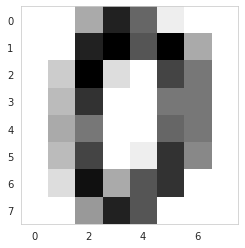

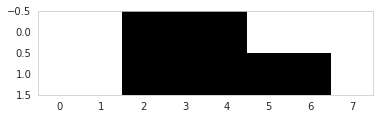

In [53]:
from sklearn.datasets import load_digits

plt.set_cmap('binary')
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')

data = load_digits()
X, _ = data.data, data.target

plt.imshow(X[0].reshape(8, 8))
plt.grid(False)
plt.show()

X = X[:,:16]
X = (X > numpy.median(X)).astype('float64')

plt.imshow(X[0].reshape(2, 8))
plt.grid(False)
plt.show()

Agregamos datos faltantes a nuestros datos:

In [48]:
numpy.random.seed(111)

i = numpy.random.randint(X.shape[0], size=5000)
j = numpy.random.randint(X.shape[1], size=5000)

X_missing = X.copy()
X_missing[i, j] = numpy.nan

array([ 0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
        1., nan,  0.])

Entrenamos una red Bayesiana con nuestros datos faltantes y llenamos los valores. Obtenemos un error de 11%:

In [49]:
model = BayesianNetwork.from_samples(X_missing, max_parents=1)
y_hat = numpy.array(model.predict(X_missing), dtype=np.float)

error = y_hat[i, j] - X[i, j]
print("Error: %.2f%%" % (numpy.abs(error).mean()*100))

Error: 10.72%


Así llenaros los valores:

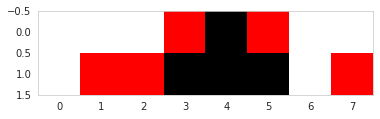

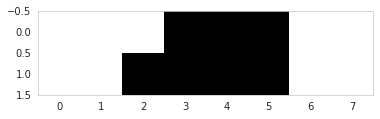

In [54]:
plt.imshow(X_missing[1].reshape(2, 8))
plt.grid(False)
plt.show()

plt.imshow(y_hat[1].reshape(2, 8))
plt.grid(False)
plt.show()